In [1]:
list_pkgs <- c("plyr", "dplyr", "tidyr", "readr", "car", "ggplot2", "cowplot")
new_pkgs <- list_pkgs[!(list_pkgs %in% installed.packages()[,"Package"])]
if(length(new_pkgs) > 0){ install.packages(new_pkgs) }

library(plyr)
library(dplyr)
library(tidyr)
library(readr)
library(car)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Outline

Introduce the basic concepts of QTL analysis -
we will start with mapping in an F2 population and later consider issues that arise in more complex populations
We should start by looking at the structure of data sets and distribution of traits.
 
We will use data from an F2 data to do basic analysis.  Typical F2 populations are formed by crosses between inbred lines, which typically differ in some trait(s) of interest. We will start with the simplest ANOVA model to look at whether there are differences in the phenotypes of the different genotypes at a locus (we will use marker 16 and trait 2a for this first analysis).
 
We will next adapt this analysis to run it as a regression model, including creating index variables to separate additive from dominance effects.
 
This basic model can be adapted as an iterative analysis that walks across markers. We can use this to test all markers for effects on trait 2a and then run the analysis for trait 3a. We will discuss use of LPR or LOD as a measure of significance.
 
For trait 2a we see a single locus, but because of LD the adjacent markers are also significant.  For trait 3a we are left with a confusing pattern - how could we identify the most likely positions of QTL?
 
How could we include marker co-factors if we want to identify positions of QTL?
 
If we run this model on a very large number of markers, how would we be able to identify significant loci?  We could correct for multiple testing, but the tests are not independent. We could use a permutation test to establish the empirical significance threshold. We can run a simple permutational model for trait 1 to establish the significance of a single test.  How can we establish the threshold for a set of tests?
 
We could also use this permutation approach simulate a true positive as a way of looking at power.

# Introduction to QTL mapping

We'll begin this tutorial with a simple unstructured F2 population. This is a population constructed by crossing a pair of inbred lines to produce a 'hybrid' F1 population and randomly crossing these F1 individuals to produce a F2. The F2 has a single generation of recombination between the genomes of the two parental lines and all individuals are equally related because they all had genetically identical parents.

![](https://raw.githubusercontent.com/diogro/QGcourse/master/tutorials/f2pop.png)

Let's first load the data we need and make some plots to see if our traits were measured and imported correctly.

# Reading and plotting data

In [2]:
f2_data = read_csv("./F2 geno pheno with QTL effect.csv")
f2_data

ID,Sex,Sire,Dam,LSB,LSW,trait1,trait2,trait3,G1,⋯,G24,G25,G26,G27,G28,G29,G30,G31,Trait2a,Trait3a
55,M,0,13,9,9,2.7840078,84.136,30.702,1,⋯,0,0,0,0,0,0,0,0,87.08466,30.70200
56,M,0,13,9,9,2.9961462,91.376,37.442,-1,⋯,0,0,0,-1,-1,-1,0,1,89.29098,34.34656
57,M,0,13,9,9,4.4964274,97.516,44.382,0,⋯,0,1,1,1,0,0,0,0,100.46466,44.38200
58,F,0,13,9,9,4.1677393,86.236,27.362,0,⋯,-1,-1,-1,-1,-1,-1,-1,-1,84.15098,25.81428
59,M,0,13,9,9,8.3322971,90.316,47.872,-1,⋯,-1,-1,-1,-1,-1,-1,0,0,88.23098,44.77656
60,F,0,13,9,9,6.0586791,74.856,31.912,1,⋯,0,0,0,0,0,0,0,0,77.80466,31.91200
61,F,0,13,9,9,5.2987302,91.926,34.582,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,89.84098,31.48656
62,M,0,13,9,9,5.0645314,95.696,45.092,1,⋯,0,0,0,0,-1,-1,-1,-1,98.64466,45.09200
63,F,0,13,9,9,4.7603125,86.126,25.982,0,⋯,0,0,0,0,0,0,0,0,89.07466,25.98200
64,F,0,13,11,11,1.0888584,91.126,32.162,1,⋯,0,0,0,0,0,0,0,0,94.07466,32.16200


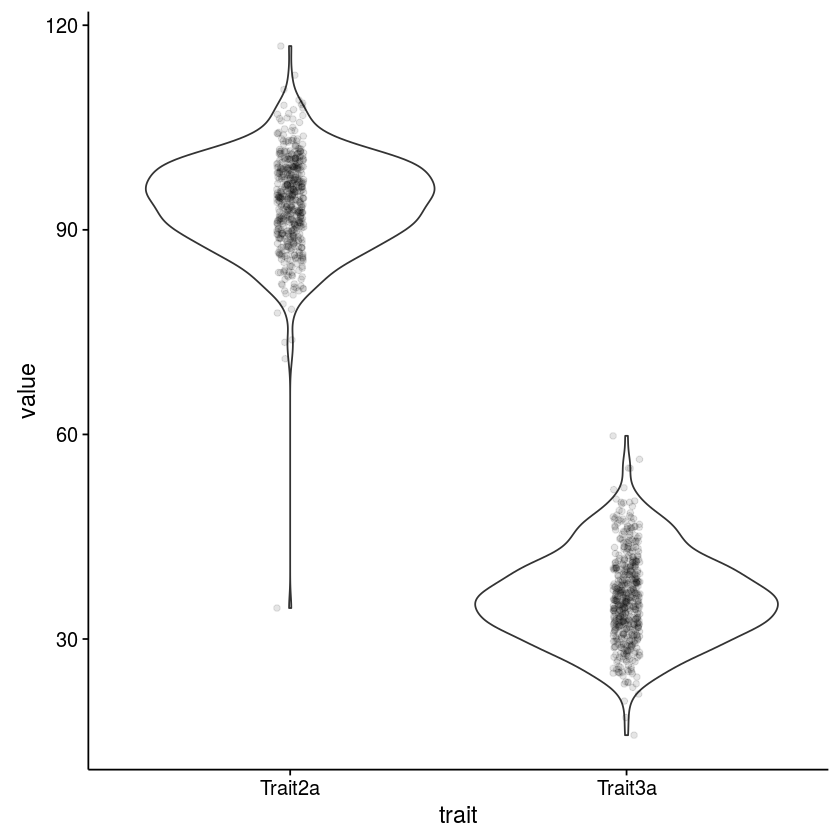

In [3]:
f2_data %>% 
    gather(trait, value, Trait2a:Trait3a) %>%
    ggplot(aes(trait, value)) + geom_violin() + geom_jitter(width = 0.1, alpha = 0.1)

# Simple single marker models

## Anova model

The simplest way of mapping a QTL is using an Anova. We divide genotypes at a particular marker position into 3 classes (the two homozygotes and the heterozygote) and look for diferences among the classes. Later we'll see how to dissect this further. This model is comparing the different genotypes states of the G16 marker with respect to the Trait2a phenotype. We are also controling for differences in Sex, litter size at birth (LSB) and litter size at weaning (LSW).

![](https://github.com/diogro/QGcourse/blob/master/tutorials/f2popQtl.png?raw=true)

The lm() function in R can be used for this test.

In [4]:
anova_fit_f2_marker_16 = lm(Trait2a ~ Sex + LSB + LSW + as.factor(G16), data = f2_data)
Anova(anova_fit_f2_marker_16)

,Sum Sq,Df,F value,Pr(>F)
Sex,1404.73117,1,36.4635275,3.064203e-09
LSB,20.72801,1,0.5380504,4.635905e-01
LSW,126.60330,1,3.2863248,7.046730e-02
as.factor(G16),3294.99693,2,42.7651971,7.470714e-18
Residuals,18992.47044,493,NA,NA


## Regression models

Another way of doing this is using a regression model, in which we code the different genotypes numericaly (-1 for one homozygote, 0 for the heterozygotes, and +1 for the other homozygote). The coeficient associated with this encoding is related to the additive effect of the marker. 

In [5]:
reg_fit_f2_marker_16_A = lm(Trait2a ~ Sex + LSB + LSW + G16, data = f2_data)
summary(reg_fit_f2_marker_16_A)


Call:
lm(formula = Trait2a ~ Sex + LSB + LSW + G16, data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-61.765  -3.641   0.339   4.085  23.938 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  89.2698     1.7463  51.121  < 2e-16 ***
SexM          3.5658     0.5854   6.091 2.26e-09 ***
LSB          -0.0885     0.1967  -0.450    0.653    
LSW           0.3557     0.2319   1.534    0.126    
G16           2.6529     0.4213   6.296 6.73e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.463 on 494 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.137,	Adjusted R-squared:   0.13 
F-statistic:  19.6 on 4 and 494 DF,  p-value: 5.486e-15


We can also use a coding of 1 for the heterozygotes and 0 for the homozygotes to extract a coefficient related to the dominance effect of the marker.

In [6]:
f2_data$G16_D = ifelse(f2_data$G16, 0, 1) # This is the dominance coding
reg_fit_f2_marker_16_AD = lm(Trait2a ~ Sex + LSB + LSW + G16 + G16_D, data = f2_data)
summary(reg_fit_f2_marker_16_AD)


Call:
lm(formula = Trait2a ~ Sex + LSB + LSW + G16 + G16_D, data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.397  -3.424   0.465   3.742  22.142 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  87.4519     1.7001  51.438  < 2e-16 ***
SexM          3.3987     0.5628   6.039 3.06e-09 ***
LSB          -0.1387     0.1890  -0.734   0.4636    
LSW           0.4040     0.2228   1.813   0.0705 .  
G16           2.7634     0.4050   6.823 2.62e-11 ***
G16_D         3.6410     0.5582   6.523 1.71e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.207 on 493 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.2055,	Adjusted R-squared:  0.1975 
F-statistic: 25.51 on 5 and 493 DF,  p-value: < 2.2e-16


# Mapping loci

If we have a set of markers we can run a series of single markers models along the chromossome to locate the position of the QTL in that cromossome. Let's create dominance collumns and run the regression models for each marker

In [7]:
n_markers = 31
marker_fits_Trait2a = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    f2_data[[paste0(current_marker, '_D')]] = ifelse(f2_data[[current_marker]], 0, 1)
    model_formula = paste0("Trait2a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits_Trait2a[[i]] = lm(as.formula(model_formula), data = f2_data)
}

Let's look at one of the model fits to see if everything is ok

In [8]:
summary(marker_fits_Trait2a[[3]])


Call:
lm(formula = as.formula(model_formula), data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-61.818  -3.749   0.048   4.309  24.783 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  89.2347     1.8463  48.332  < 2e-16 ***
SexM          3.6262     0.6058   5.986 4.14e-09 ***
LSB          -0.1426     0.2034  -0.701   0.4835    
LSW           0.4282     0.2398   1.786   0.0748 .  
G3            1.0665     0.4310   2.474   0.0137 *  
G3_D         -0.2116     0.5992  -0.353   0.7242    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.682 on 493 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.07934,	Adjusted R-squared:   0.07 
F-statistic: 8.497 on 5 and 493 DF,  p-value: 9.933e-08


We can use this set of fits to see how the log significance changes along the cromossome. The regression model allows us to separate the additive and dominance effects.

### First the additive signficance

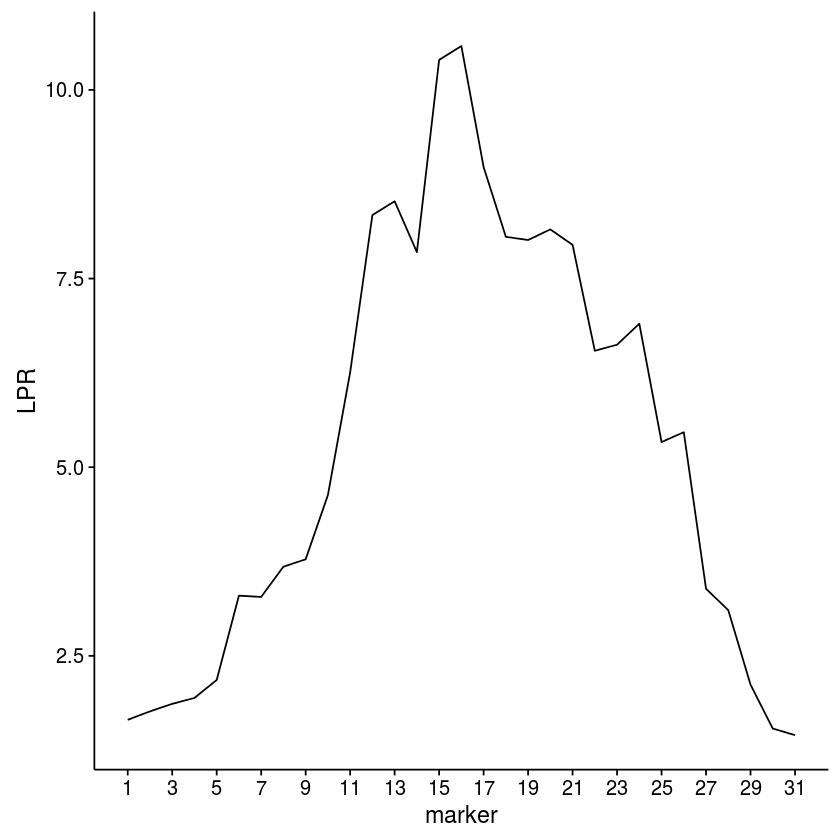

In [9]:
ldply(marker_fits_Trait2a, function(x) summary(x)$coefficients[5, 'Pr(>|t|)']) %>%
    ggplot(aes(1:n_markers, -log10(V1))) + geom_line() + labs(x = "marker", y = "LPR") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2))

### Now the dominance significance

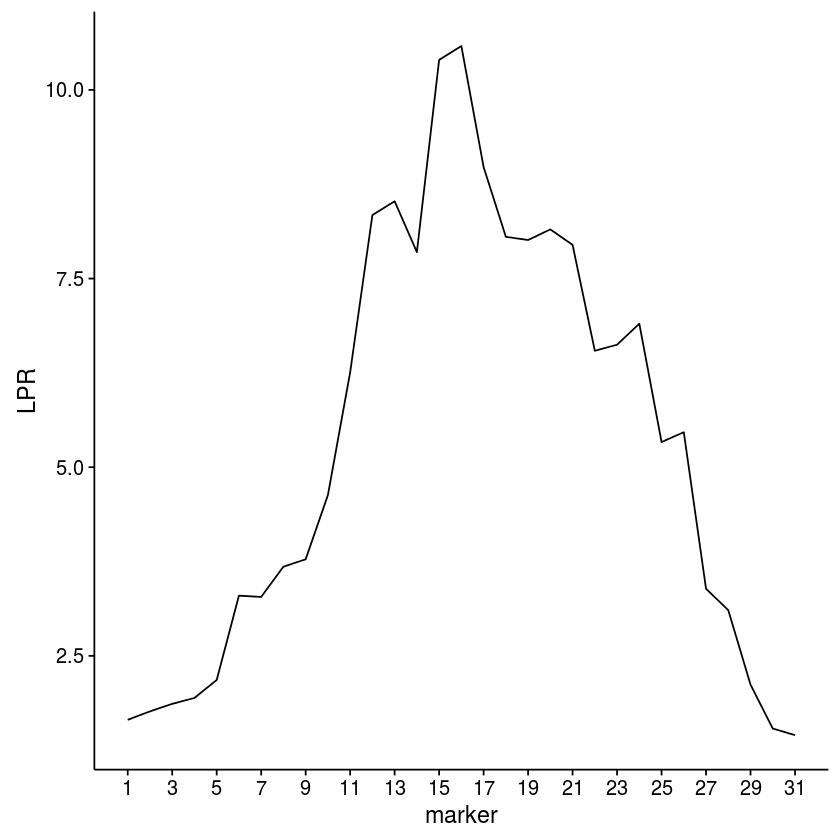

In [10]:
ldply(marker_fits_Trait2a, function(x) summary(x)$coefficients[5, 'Pr(>|t|)'])    %>%
    ggplot(aes(1:n_markers, -log10(V1))) + geom_line() + labs(x = "marker", y = "LPR") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2))

We could also do both graphs at once using some faceting.

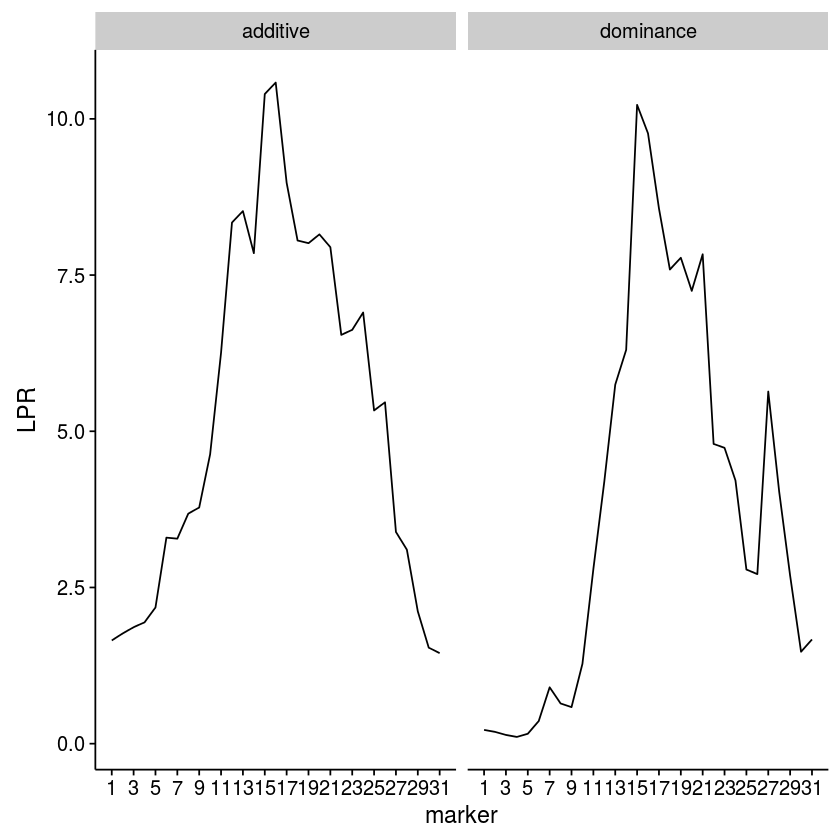

In [11]:
# Additive and dominance significance ploted together
ldply(marker_fits_Trait2a, function(x) summary(x)$coefficients[c(5, 6), 'Pr(>|t|)']) %>% 
    rename(additive = G1, dominance = G1_D) %>%
    mutate(marker = 1:n_markers) %>%
    gather(variable, value, additive:dominance) %>%    
ggplot(aes(marker, -log10(value)), group = variable) + 
    geom_line() + labs(x = "marker", y = "LPR") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2)) + facet_wrap(~variable)

## More than one effect

In [12]:
n_markers = 31
marker_fits_Trait3a = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    model_formula = paste0("Trait3a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits_Trait3a[[i]] = lm(as.formula(model_formula), data = f2_data)
}

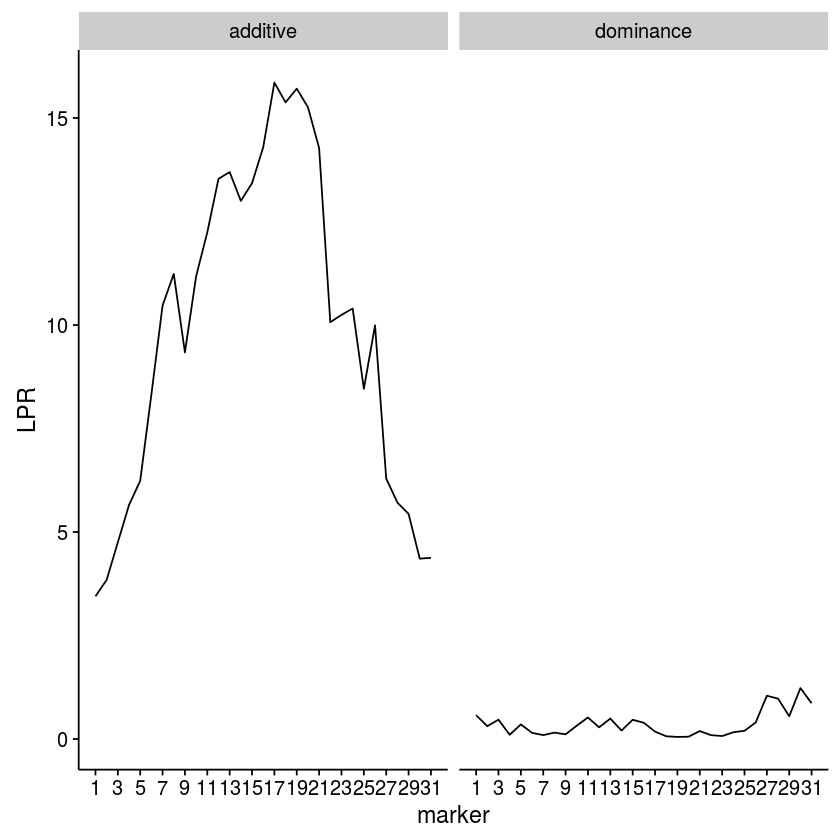

In [13]:
ldply(marker_fits_Trait3a, function(x) summary(x)$coefficients[c(5, 6), 'Pr(>|t|)']) %>% 
    rename(additive = G1, dominance = G1_D) %>%
    mutate(marker = 1:n_markers) %>%
    gather(variable, value, additive:dominance) %>%    
ggplot(aes(marker, -log10(value)), group = variable) + 
    geom_line() + labs(x = "marker", y = "LPR") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2)) + facet_wrap(~variable)

## Including more than one marker in a model

We can take LD into account in the mapping by including flanking markers. This provides more localised estimates of the QTLs.

In [14]:
fit_f2_m13         = lm(Trait2a ~ Sex + LSB + LSW + G13 + G13_D                            , data = f2_data)
fit_f2_m13_fl11_15 = lm(Trait2a ~ Sex + LSB + LSW + G13 + G13_D + G11 + G11_D + G15 + G15_D, data = f2_data)
summary(fit_f2_m13)$coefficients
summary(fit_f2_m13_fl11_15)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),87.6405709,1.7584448,49.8398183,1.242938e-194
SexM,3.5589252,0.5771751,6.1661101,1.458395e-09
LSB,-0.1477513,0.1939037,-0.7619831,4.464344e-01
LSW,0.4308590,0.2289043,1.8822668,6.038852e-02
G13,2.4783795,0.4101400,6.0427646,2.989783e-09
G13_D,2.7697281,0.5730483,4.8333237,1.796375e-06


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),87.54050836,1.7178712,50.95871522,9.556054e-198
SexM,3.47284543,0.5628614,6.16998338,1.433808e-09
LSB,-0.15554123,0.1899232,-0.81896904,4.132030e-01
LSW,0.42661370,0.2237477,1.90667265,5.714880e-02
G13,-0.02139369,1.3164233,-0.01625138,9.870405e-01
G13_D,-0.15242632,1.3276670,-0.11480764,9.086447e-01
G11,-0.20063827,0.9288979,-0.21599605,8.290809e-01
G11_D,-1.36413615,1.0484438,-1.30110570,1.938350e-01
G15,2.84037161,0.9999768,2.84043763,4.693044e-03
G15_D,4.83151406,1.0118631,4.77486922,2.379731e-06


Now let's redo all the individual markers, but including 2 flanking markers in the models. The markers at the edge of the chromossome only get one flanking marker.

In [15]:
n_markers = 31
interval = 6 # Play around with this value. 
fl_marker_fits_Trait3a = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    f2_data[[paste0(current_marker, '_D')]] = ifelse(f2_data[[current_marker]], 0, 1)
    model_formula = paste0("Trait3a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    if((i - interval) >= 1)
        model_formula = paste0(model_formula, "+ G", paste0(i - interval), "+ G", paste0(i - interval), "_D")
    if((i + interval) <= n_markers)
        model_formula = paste0(model_formula, "+ G", paste0(i + interval), "+ G", paste0(i + interval), "_D")
    fl_marker_fits_Trait3a[[i]] = lm(as.formula(model_formula), data = f2_data)
}

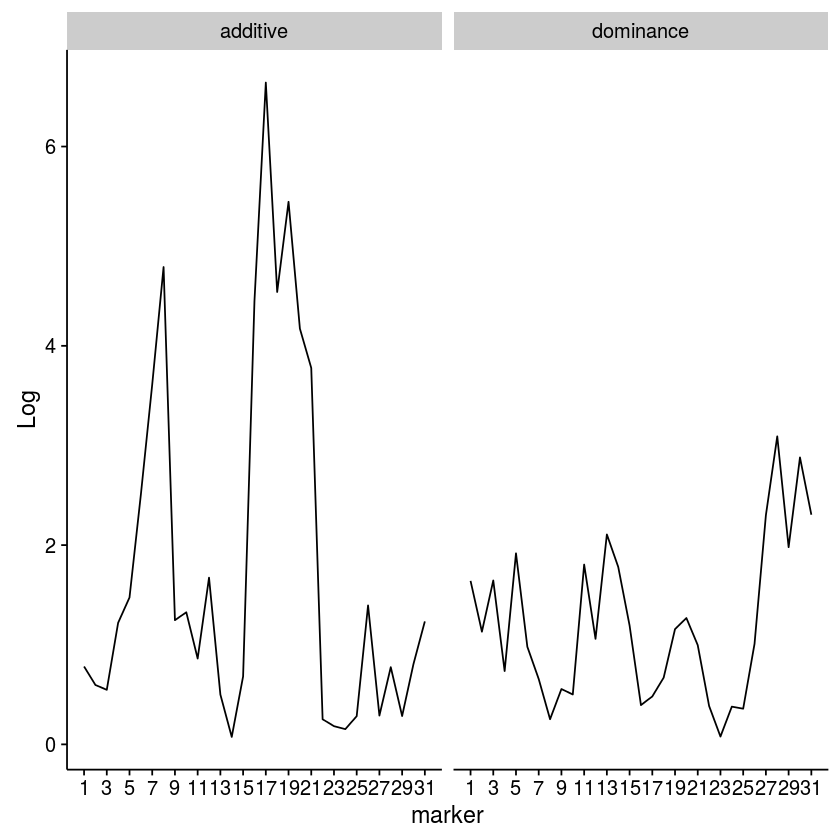

In [16]:
ldply(fl_marker_fits_Trait3a, function(x) summary(x)$coefficients[c(5, 6), 'Pr(>|t|)']) %>% 
    rename(additive = G1, dominance = G1_D) %>%
    mutate(marker = 1:n_markers) %>%
    gather(variable, value, additive:dominance) %>%    
ggplot(aes(marker, -log(value)), group = variable) + 
    geom_line() + labs(x = "marker", y = "Log") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2)) + facet_wrap(~variable)

# Type I error rate

Let's run a null model, with no QTLs, and see how many false postives we get. The expectation is the significance treashold we choose (5% maybe?).

In [17]:
simulated_genotypes = read_csv("sim genotypes.csv")
f2_data_null = inner_join(select(f2_data, ID:trait3), simulated_genotypes, by = "ID")
f2_data_null

ID,Sex,Sire,Dam,LSB,LSW,trait1,trait2,trait3,G1,⋯,G991,G992,G993,G994,G995,G996,G997,G998,G999,G1000
55,M,0,13,9,9,2.7840078,84.136,30.702,1,⋯,-1,0,0,-1,0,-1,-1,-1,-1,1
56,M,0,13,9,9,2.9961462,91.376,37.442,-1,⋯,-1,0,-1,1,0,1,-1,1,0,0
57,M,0,13,9,9,4.4964274,97.516,44.382,0,⋯,0,0,-1,0,-1,1,1,1,1,-1
58,F,0,13,9,9,4.1677393,86.236,27.362,0,⋯,-1,0,0,1,-1,-1,1,0,-1,0
59,M,0,13,9,9,8.3322971,90.316,47.872,-1,⋯,1,1,0,1,0,0,0,0,-1,-1
60,F,0,13,9,9,6.0586791,74.856,31.912,1,⋯,1,0,-1,0,0,0,0,-1,0,0
61,F,0,13,9,9,5.2987302,91.926,34.582,-1,⋯,-1,1,-1,0,1,0,0,0,1,-1
62,M,0,13,9,9,5.0645314,95.696,45.092,1,⋯,0,-1,0,1,0,0,-1,1,0,0
63,F,0,13,9,9,4.7603125,86.126,25.982,0,⋯,1,0,1,0,0,0,-1,0,0,0
64,F,0,13,11,11,1.0888584,91.126,32.162,1,⋯,0,1,0,0,0,0,0,0,0,1


In [18]:
null_markers = 675
marker_fits_trait1 = list()
for(i in seq(null_markers)){
    current_marker = paste0('G', i)
    f2_data_null[[paste0(current_marker, '_D')]] = ifelse(f2_data_null[[current_marker]], 0, 1)
    model_formula = paste0("trait1 ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits_trait1[[i]] = lm(as.formula(model_formula), data = f2_data_null)
}

In [19]:
table(laply(marker_fits_trait1, function(x) summary(x)$coefficients[5, 'Pr(>|t|)']) < 0.05) / null_markers


     FALSE       TRUE 
0.95555556 0.04444444 